## Data Merging and Cleaning

This file assembles two "master" dataframes for experimentation. The first dataframe contains every crime throughout each day, with associated daily weather information. The second dataframe contains the number of arrests each day with associated mean weather information.

### How to use:

1. **Download CSV data and place in the ./input directory**
    - [NYPD_Arrest_Data__Year_to_Date_.csv](https://drive.google.com/file/d/1Ee7dSLLK7EdiMwiE94uK3p0SiDd7vTrP/view?usp=sharing)
    - [NYPD_Arrests_Data__Historic_.csv](https://drive.google.com/file/d/1g_Iok1V2NnWKBy0r9qGG7XavUlOhDzWe/view?usp=sharing)
    - [daily_new_york_data.csv](https://drive.google.com/file/d/1_B0xP4ORTzHCG9S4LaEB_yEjC1mvITXU/view?usp=sharing)
2. **Run cells in order from top to bottom**
    - Run all cells in order
    - Run all cells only once
3. **View output in the ./output directory**
    - We can either output files in our program, or call this module directly from another module to receive this data.

In [1]:
import numpy as np
import pandas as pd

### Arrests source data

We can load all arrests, or filter by law codes or by level of offense. If we don't want to filter anything, then everything in the next two cells should be commented out. If we want to filter by one or both, uncomment one or both cells and set the variables to the desired values.

**Dataset**
   - Historic arrest dataset: https://data.cityofnewyork.us/Public-Safety/NYPD-Arrest-Data-Year-to-Date-/uip8-fykc
   - Current arrest dataset: https://data.cityofnewyork.us/Public-Safety/NYPD-Arrests-Data-Historic-/8h9b-rp9u
   - New York State Penal Law Offenses: https://ypdcrime.com/penallawlist.php?tfm_order=DESC&tfm_orderby=code
    
**Resources**
   - New York State Penal Law Offenses: https://ypdcrime.com/penallawlist.php?tfm_order=DESC&tfm_orderby=code
   - Laws of New York: https://ypdcrime.com/penal.law/

#### Load data

In [2]:
historic_arrests = pd.read_csv('./input/NYPD_Arrests_Data__Historic_.csv')

In [3]:
current_arrests = pd.read_csv('./input/NYPD_Arrest_Data__Year_to_Date_.csv')

In [4]:
# Sanity check.
print('Number of unique dates: ' + str(len(current_arrests['ARREST_DATE'].unique()) + len(historic_arrests['ARREST_DATE'].unique())))

Number of unique dates: 5752


In [5]:
# Sanity check.
print('Number of arrests: ' + str(len(current_arrests['ARREST_DATE']) + len(historic_arrests['ARREST_DATE'])))

Number of arrests: 5268668


In [6]:
# Append historic data to current data for a full list.
total_arrests = current_arrests.append(historic_arrests)

#### Format data

In [ ]:
total_arrests.dropna(subset=['PD_DESC', 'OFNS_DESC'], inplace=True)

In [7]:
def format_date_arrests(date):
    split = date.split('/')
    return split[2] + split[0] + split[1]

In [8]:
total_arrests['date'] = total_arrests['ARREST_DATE'].apply(format_date_arrests)

In [9]:
# Only return abbreviated NY penal codes.
def get_law_code_prefix(code):
    if type(code) == str:
        if code[:3] == 'PL ': 
            return code[3:6] # First three numerals.
    return np.nan

In [10]:
# Create a column with just the first five characters of the law code for filtering.
total_arrests['law_code_abbr'] = total_arrests['LAW_CODE'].apply(get_law_code_prefix)

In [34]:
# Label each arrest with an offense category using the
# law_code_abbr column to identify the offense.

offenses = {
    'Anticipatory Offenses': [100, 115],
    'Offenses Against the Person': [120, 135],
    'Damage to Property Offenses': [140, 150],
    'Theft Offenses': [155, 165],
    'Fraud Offenses': [170, 190],
    'Public Administration Offenses': [195, 215],
    'Public Health, Morals Offenses': [220, 235],
    'Public Order, Privacy': [240, 250],
    'Family, Welfare of Children': [255, 263],
    'Public Safety Offenses': [265, 275]
}

def get_offense(code):
    code = int(code)
    for key, value in offenses.items():
        code_min = value[0]
        code_max = value[1]
        if (code >= code_min) & (code <= code_max):
            return key

In [12]:
# Ignore arrests that are not categorized.
total_arrests.dropna(subset=['law_code_abbr'], inplace=True)

# Add offense categories to arrests for filtering later.
total_arrests['law_code_desc'] = total_arrests['law_code_abbr'].apply(get_offense)

In [13]:
# Save total_arrests as a checkpoint for debugging.
arrests = total_arrests

### Weather source data

#### Hourly weather

In [14]:
hourly_weather = pd.read_csv('./input/daily_new_york_data.csv')

# Grabbing more than temperature just so they're handy if we want to play a bit.
hourly_weather = hourly_weather[['dt', 'temp', 'feels_like', 'temp_min', 'temp_max', 
               'humidity', 'wind_speed', 'wind_deg', 'rain_1h', 
               'rain_3h', 'snow_1h', 'snow_3h', 'clouds_all']]

In [15]:
# Sanity check.
print('Total of hours of weather data: ' + str(len(hourly_weather)))

Total of hours of weather data: 130490


In [16]:
from datetime import datetime
from pytz import timezone # for timezone awareness

def format_date_weath(dt):
    localtz = timezone('America/New_York')
    dt_unaware = datetime.fromtimestamp(dt)
    dt_aware = localtz.localize(dt_unaware, is_dst=None)
    return datetime.utcfromtimestamp(dt_aware).strftime('%Y%m%d')

In [17]:
# Format dates like the other dataframes.
hourly_weather['date'] = hourly_weather['dt'].apply(lambda dt: datetime.utcfromtimestamp(dt).strftime('%Y%m%d'))

#### Daily weather

In [18]:
# Daily weather averages and extremes.
daily_weather = hourly_weather

daily_weather[['rain_1h', 'rain_3h', 
            'snow_1h', 'snow_3h']] = daily_weather[['rain_1h', 'rain_3h', 
                                                'snow_1h', 'snow_3h']].fillna(value=0)

daily_weather = daily_weather.groupby(['date']).agg({'temp':'mean', 'feels_like':'mean', 
                                        'temp_min': 'min', 'temp_max': 'max',
                                        'humidity': 'mean', 'wind_speed': 'mean',
                                        'wind_deg': 'mean', 'rain_1h': 'mean',
                                        'rain_3h': 'mean', 'snow_1h': 'mean',
                                        'snow_3h': 'mean', 'clouds_all': 'mean'})

daily_weather['date'] = daily_weather.index

In [19]:
# Sanity check.
print('Total number of days: ' + str(len(daily_weather)))

Total number of days: 5071


### All arrests

This dataframe contains more detail, including each arrest's description and location in the city, by borough. This dataset may or may not be used, depending if we have time to do extra fancy visualizations. Otherwise, the next dataframe showing daily summaries are what we'll focus on first.

In [20]:
# Set date as index for merging.
arrests.set_index(['date'], inplace=True)

In [21]:
# Merge arrest data and weather data.
all_arrests = pd.merge(left=arrests, right=daily_weather, how='left',
                        left_index=True, right_index=True)

all_arrests.dropna(inplace=True)

all_arrests.columns = all_arrests.columns.str.lower()

all_arrests = all_arrests[['pd_desc', 'ofns_desc', 'law_code', 'law_cat_cd', 
                           'arrest_boro', 'age_group', 'perp_sex', 'perp_race', 'temp', 
                           'feels_like', 'temp_min', 'temp_max', 'humidity', 
                           'wind_speed', 'wind_deg', 'rain_1h', 'rain_3h', 
                           'snow_1h', 'snow_3h', 'law_code_abbr', 'law_code_desc']]

In [22]:
# Sanity check.
print('Total number of arrests: ' + str(len(all_arrests)))

Total number of arrests: 0


In [23]:
# Convert borough code to borough name.
def get_borough(b):
    if b == 'B':
        return 'The Bronx'
    elif b == 'K':
        return 'Brooklyn'
    elif b == 'M':
        return 'Manhattan'
    else:
        return 'Queens'

In [24]:
# Clean up categorical text.
all_arrests['pd_desc'] = all_arrests['pd_desc'].str.capitalize()
all_arrests['ofns_desc'] = all_arrests['ofns_desc'].str.capitalize()
all_arrests['arrest_boro'] = all_arrests['arrest_boro'].apply(get_borough)

#### Write to file

In [25]:
all_arrests.to_csv('./output/all_arrests.csv')

### Daily Arrests

This dataframe will likely be our primary dataset, since it's giving us a day-by-day arrest count with the mean weather conditions for that day.

In [26]:
daily_arrests = all_arrests

#### Filter arrests by law code and level

In [27]:
# Filter arrests.
daily_arrests = daily_arrests[daily_arrests['law_code_desc'] == 'Offenses Against the Person']
daily_arrests = daily_arrests[daily_arrests['law_cat_cd'] == 'F']

In [28]:
# Aggregate arrests into daily summaries.
daily_arrests = daily_arrests.groupby(['date']).count()
daily_arrests.drop(columns=['ofns_desc', 'law_code_desc', 'arrest_boro'], inplace=True)
daily_arrests.rename(columns={'pd_desc': 'num_arrests'}, inplace=True)
daily_arrests = daily_arrests[['num_arrests']]
daily_arrests = pd.merge(left=daily_arrests, right=daily_weather, 
                      how='left', left_index=True, right_index=True)

In [29]:
# Sanity check.
print('Total number of daily arrests: ' + str(daily_arrests['num_arrests'].sum()))

Total number of daily arrests: 0


In [30]:
# Sanity check.
print('Total number of days: ' + str(len(daily_arrests)))

Total number of days: 0


#### Write to file

In [31]:
daily_arrests.to_csv('./output/daily_arrests.csv')

### EDA

Display a quick pairplot to quickly see if there's any correleation between number of arrests per day and weather conditions.

In [32]:
daily_arrests.head()

,num_arrests,temp,feels_like,temp_min,temp_max,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_1h,snow_3h,clouds_all,date
date,,,,,,,,,,,,,,


#### Visualizations

Text(0.5, 1.0, 'Snow: 3 Hours')

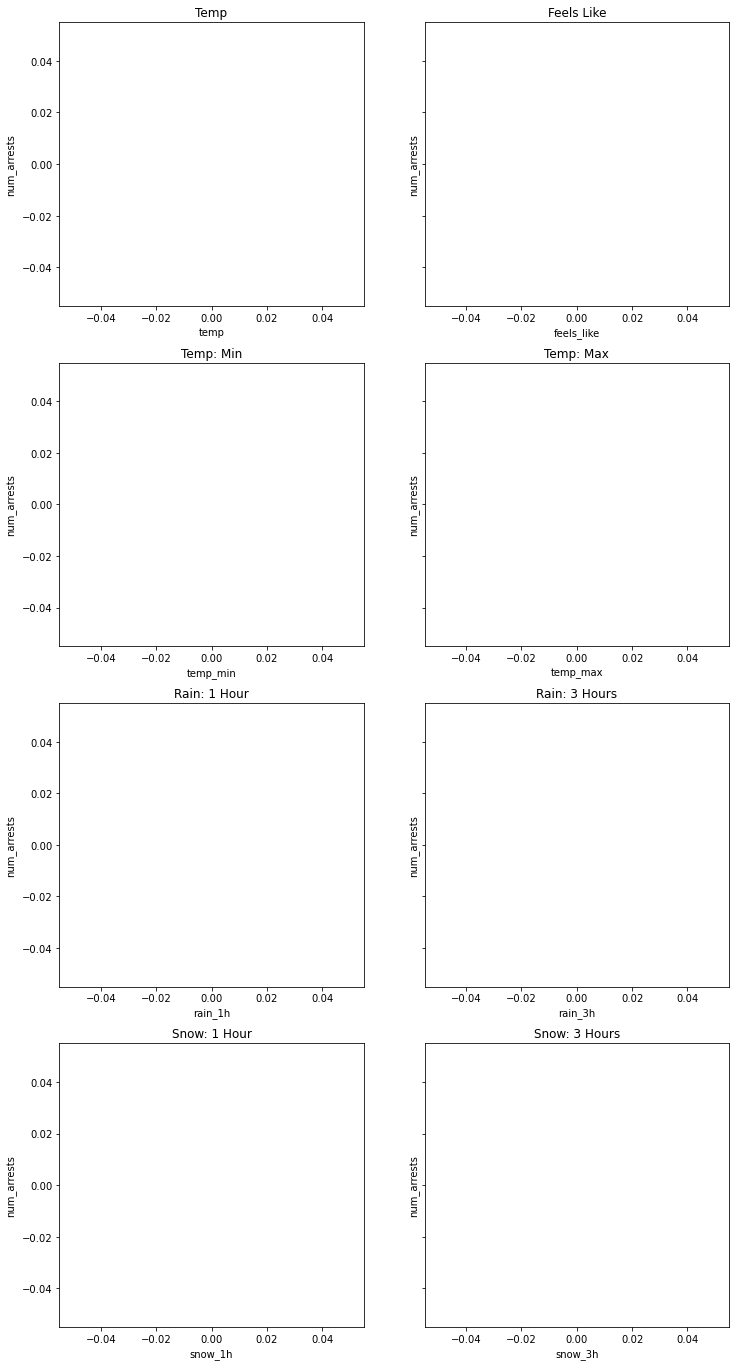

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(ncols=2, nrows=4, sharey=True, figsize=(12, 24))
ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8 = ax.flatten()
scatter_toggle = False

sns.regplot(x=daily_arrests['temp'], y=daily_arrests['num_arrests'], ax=ax1, scatter=scatter_toggle).set_title("Temp")
sns.regplot(x=daily_arrests['feels_like'], y=daily_arrests['num_arrests'], ax=ax2, scatter=scatter_toggle).set_title("Feels Like")
sns.regplot(x=daily_arrests['temp_min'], y=daily_arrests['num_arrests'], ax=ax3, scatter=scatter_toggle).set_title("Temp: Min")
sns.regplot(x=daily_arrests['temp_max'], y=daily_arrests['num_arrests'], ax=ax4, scatter=scatter_toggle).set_title("Temp: Max")
sns.regplot(x=daily_arrests['rain_1h'], y=daily_arrests['num_arrests'], ax=ax5, scatter=scatter_toggle).set_title("Rain: 1 Hour")
sns.regplot(x=daily_arrests['rain_3h'], y=daily_arrests['num_arrests'], ax=ax6, scatter=scatter_toggle).set_title("Rain: 3 Hours")
sns.regplot(x=daily_arrests['snow_1h'], y=daily_arrests['num_arrests'], ax=ax7, scatter=scatter_toggle).set_title("Snow: 1 Hour")
sns.regplot(x=daily_arrests['snow_3h'], y=daily_arrests['num_arrests'], ax=ax8, scatter=scatter_toggle).set_title("Snow: 3 Hours")

### Remarks

There's some correlation when we restrict the dataset to particular offense categories and particular offense levels. Heat seems to have a slight positive correlation with number of arrests. Rain and snow have a higher, negative correlations with number of arrests.